In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import joblib

DATA_DIR = Path("Data")

In [2]:
def prepare_dataset(kind: str):
    # 1) Cargar X e Y
    if kind == "fourier":
        X_df = pd.read_csv(DATA_DIR / "X" / "X_fourier.csv")
    elif kind == "metrics":
        X_df = pd.read_csv(DATA_DIR / "X" / "X_metrics.csv")
    else:
        raise ValueError("kind debe ser 'fourier' o 'metrics'")

    Y_df = pd.read_csv(DATA_DIR / "Y" / "Y.csv")

    # 2) Merge igual que en los notebooks 2 y 3
    data = X_df.merge(
        Y_df[[
            "filename", "VehId", "DayNum", "Trip",
            "Y_consumption_combustion_L_per_100km",
            "Y_consumption_electric_kWh_per_km"
        ]],
        on=["filename", "VehId", "DayNum", "Trip"],
        how="inner"
    )

    # 3) Misma lista de columnas excluidas
    exclude_cols = [
        "filename", "DayNum", "Trip", "Timestamp", "Timestamp(ms)",
        "Y_consumption_combustion_L_per_100km",
        "Y_consumption_electric_kWh_per_km"
    ]

    # columnas numéricas que sí usamos
    feature_cols = [
        col for col in data.columns
        if col not in exclude_cols
        and col != "VehId"
        and col != "filename"
        and data[col].dtype in [np.float64, np.int64]
    ]

    # X e y igual que en los notebooks
    X = data[feature_cols].fillna(data[feature_cols].mean())
    target_col = "Y_consumption_combustion_L_per_100km"
    y = data[target_col].fillna(data[target_col].mean()).values

    # 4) Split EXACTAMENTE igual que ahí (random_state=69)
    indices = np.arange(len(X))

    # dev (80%) vs test (20%)
    idx_dev, idx_test, X_dev, X_test, y_dev, y_test = train_test_split(
        indices, X, y, test_size=0.2, random_state=69
    )

    # de dev: train (80%) vs val (20%)
    idx_train, idx_val, X_train, X_val, y_train, y_val = train_test_split(
        idx_dev, X_dev, y_dev, test_size=0.2, random_state=69
    )

    # 5) Escalador igual que en el notebook: fit en X_train
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_scaled = pd.DataFrame(
        scaler.transform(X_train),
        columns=feature_cols,
        index=X_train.index
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val),
        columns=feature_cols,
        index=X_val.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=feature_cols,
        index=X_test.index
    )

    # 6) Nombres “sanitizados” para XGBoost (idéntico al código original)
    sanitized_feature_cols = [
        col.replace("[", "").replace("]", "").replace("<", "").replace(">", "")
        for col in feature_cols
    ]
    X_train_scaled.columns = sanitized_feature_cols
    X_val_scaled.columns = sanitized_feature_cols
    X_test_scaled.columns = sanitized_feature_cols

    # ids del test para chequear que Fourier y Metrics usan las mismas filas
    ids_test = data.loc[idx_test, ["filename", "VehId", "DayNum", "Trip"]].reset_index(drop=True)

    return X_test_scaled, y_test, ids_test


In [3]:
# Preparar datasets
X_fourier_test, y_test_fourier, ids_fourier = prepare_dataset("fourier")
X_metrics_test, y_test_metrics, ids_metrics = prepare_dataset("metrics")

print("Fourier test shape:", X_fourier_test.shape)
print("Metrics test shape:", X_metrics_test.shape)

# Verificamos que estén alineados (mismas muestras)
print("\n¿Y_test coincide en ambos casos?:", np.allclose(y_test_fourier, y_test_metrics))
print("¿IDs coinciden?:", (ids_fourier == ids_metrics).all().all())

# Usamos un único y_test
y_test = y_test_fourier

# Cargar mejores modelos que guardaste
best_fourier = joblib.load("models/saved_models/fourier/Random_Forest_best.pkl")
best_metrics = joblib.load("models/saved_models/metrics/XGBoost_best.pkl")

# Ahora sí, PREDICT sin errores de columnas
pred_fourier = best_fourier.predict(X_fourier_test)
pred_metrics = best_metrics.predict(X_metrics_test)

C:\Users\joaco\AppData\Local\Temp\ipykernel_5316\3737307211.py:6: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  X_df = pd.read_csv(DATA_DIR / "X" / "X_metrics.csv")


Fourier test shape: (6509, 156)
Metrics test shape: (6509, 104)

¿Y_test coincide en ambos casos?: True
¿IDs coinciden?: True


,Model,MSE,MAE,R2
0,Fourier - Random Forest,0.194058,0.043074,0.824283
1,Metrics - XGBoost,0.112790,0.030461,0.897871


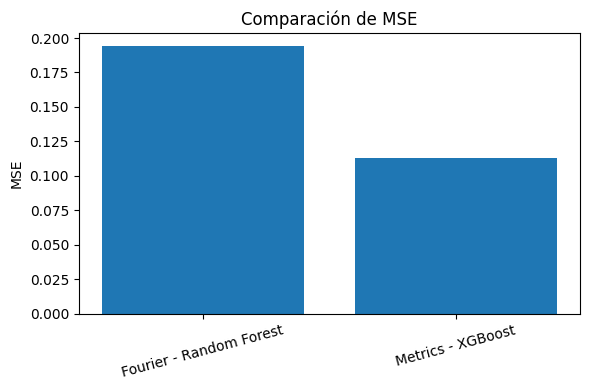

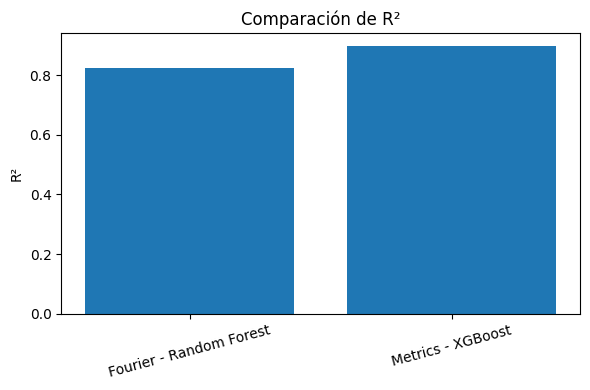

In [4]:
results = {
    "Model": ["Fourier - Random Forest", "Metrics - XGBoost"],
    "MSE": [
        mean_squared_error(y_test, pred_fourier),
        mean_squared_error(y_test, pred_metrics),
    ],
    "MAE": [
        mean_absolute_error(y_test, pred_fourier),
        mean_absolute_error(y_test, pred_metrics),
    ],
    "R2": [
        r2_score(y_test, pred_fourier),
        r2_score(y_test, pred_metrics),
    ],
}

df_results = pd.DataFrame(results)
display(df_results)

# Gráfico MSE
plt.figure(figsize=(6,4))
plt.bar(df_results["Model"], df_results["MSE"])
plt.xticks(rotation=15)
plt.ylabel("MSE")
plt.title("Comparación de MSE")
plt.tight_layout()
plt.show()

# Gráfico R2
plt.figure(figsize=(6,4))
plt.bar(df_results["Model"], df_results["R2"])
plt.xticks(rotation=15)
plt.ylabel("R²")
plt.title("Comparación de R²")
plt.tight_layout()
plt.show()
